In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Q1Data.csv to Q1Data.csv


# Decision Tree From Scratch

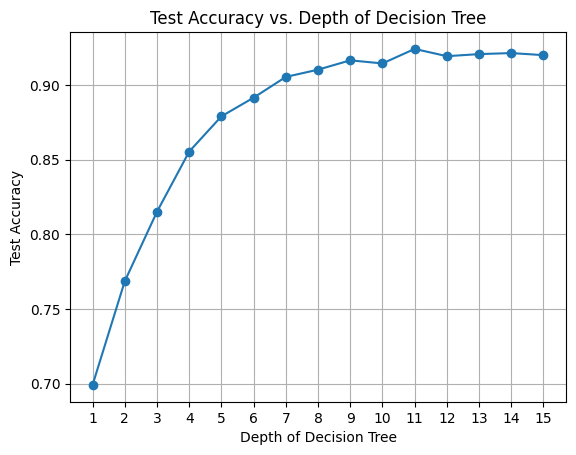

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

df = pd.read_csv("Q1Data.csv")

X = df.iloc[:, 1:7].values
y = df['Genus'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)

        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)


def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

depths = range(1, 16)
test_accuracies = []

for depth in depths:
    dt = DecisionTree(max_depth=depth)
    dt.fit(X_train, y_train_encoded)
    y_pred = dt.predict(X_test)
    acc = accuracy(y_test_encoded, y_pred)
    test_accuracies.append(acc)

plt.plot(depths, test_accuracies, marker='o')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Depth of Decision Tree')
plt.xticks(range(1, 16))
plt.grid(True)
plt.show()


# Observation :-
- Initial depth increases improve accuracy by capturing intricate patterns.
- As depth increases, accuracy gains diminish due to over-complexity.
- Beyond a certain depth, accuracy plateaus, indicating diminishing returns.
- A slight fall in accuracy suggests potential overfitting to training data.
- Subsequent marginal rises might capture additional noise, but don't generalize well.
- Peak accuracy at depth 15 indicates an optimal balance between complexity and performance.


# KNN from scratch

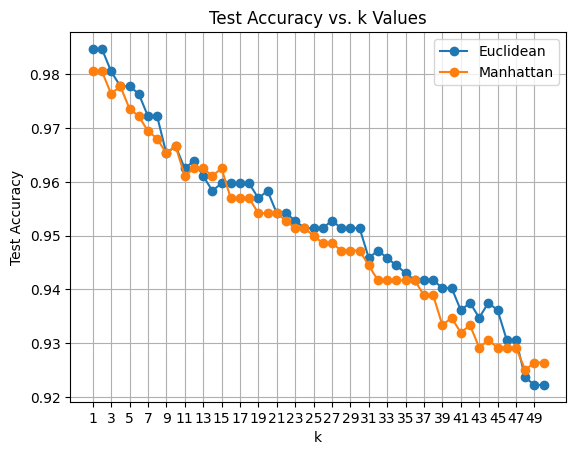

In [5]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv("Q1Data.csv")

X = df.iloc[:, :-3].values
y = df['Genus'].values

class KNN:
    def __init__(self, k, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return predictions

    def _predict(self, x):
        distances = [self._distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

    def _distance(self, x1, x2):
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.3, random_state=42)

test_accuracies_euclidean = []
test_accuracies_manhattan = []
k_values = range(1, 51)

for k in k_values:
    knn_euclidean = KNN(k=k, distance_metric='euclidean')
    knn_euclidean.fit(X_train, y_train)
    y_pred_euclidean = knn_euclidean.predict(X_test)
    acc_euclidean = np.sum(y_pred_euclidean == y_test) / len(y_test)
    test_accuracies_euclidean.append(acc_euclidean)

    knn_manhattan = KNN(k=k, distance_metric='manhattan')
    knn_manhattan.fit(X_train, y_train)
    y_pred_manhattan = knn_manhattan.predict(X_test)
    acc_manhattan = np.sum(y_pred_manhattan == y_test) / len(y_test)
    test_accuracies_manhattan.append(acc_manhattan)

plt.plot(k_values, test_accuracies_euclidean, label='Euclidean', marker='o', linestyle='-')
plt.plot(k_values, test_accuracies_manhattan, label='Manhattan', marker='o', linestyle='-')
plt.title('Test Accuracy vs. k Values')
plt.xlabel('k')
plt.ylabel('Test Accuracy')
plt.xticks(range(1, 51, 2))
plt.legend()
plt.grid(True)
plt.show()


# Observation :-
- **Nearest Neighbor Influence**: As \( k \) increases from 1 to 50, more neighbors are considered for classification.
- **Euclidean Distance**: It considers more distant neighbors as \( k \) increases, potentially leading to misclassification.
- **Manhattan Distance**: Similar to Euclidean, but less affected by outliers due to its sensitivity.
- **Accuracy Decrease**: Accuracy drops from approximately 98% to 89% (Euclidean) and 90% (Manhattan) with increasing \( k \).
- **High \( k \) Values**: The model becomes less sensitive to local variations.
- **Balancing Act**: Finding a suitable \( k \) value is crucial for balancing local patterns and avoiding overfitting.


# KNN and Decision Tree using inbuilt functions of Scikit-Learn

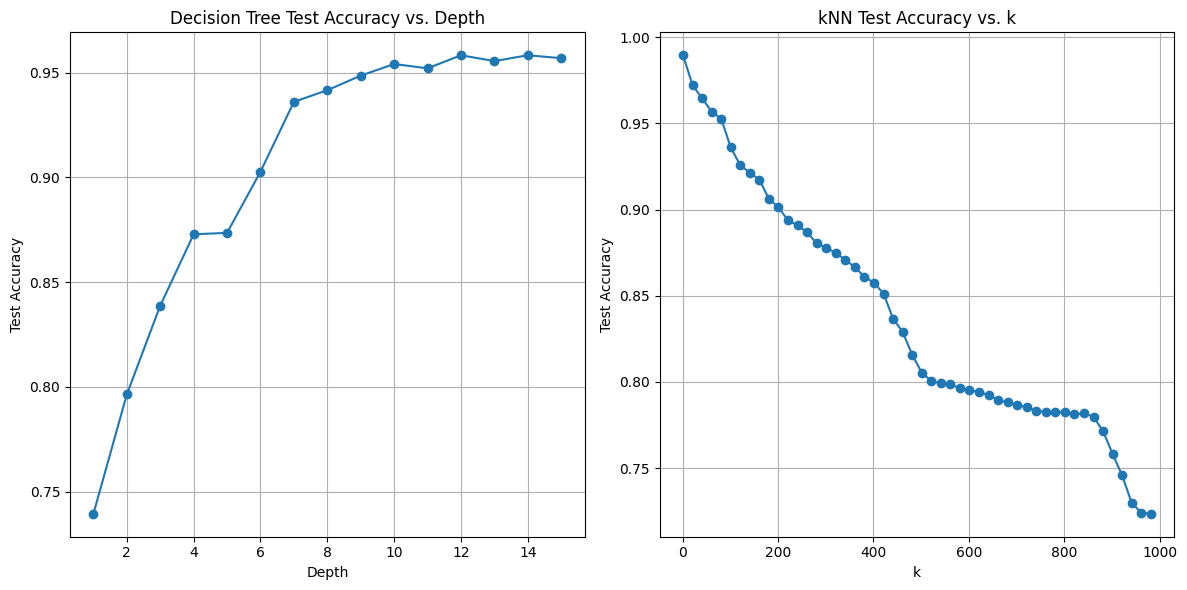

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

df = pd.read_csv("Q1Data.csv")

X = df.iloc[:, :-3].values
y = df['Genus'].values

depth_values = range(1, 16)
test_accuracies_dt = []

for depth in depth_values:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    dt_classifier = DecisionTreeClassifier(max_depth=depth)
    dt_classifier.fit(X_train, y_train)
    test_accuracy = dt_classifier.score(X_test, y_test)
    test_accuracies_dt.append(test_accuracy)

k_values = range(1, 1001, 20)
test_accuracies_knn = []

for k in k_values:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    test_accuracy = knn_classifier.score(X_test, y_test)
    test_accuracies_knn.append(test_accuracy)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(depth_values, test_accuracies_dt, marker='o', linestyle='-')
plt.title('Decision Tree Test Accuracy vs. Depth')
plt.xlabel('Depth')
plt.ylabel('Test Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, test_accuracies_knn, marker='o', linestyle='-')
plt.title('kNN Test Accuracy vs. k')
plt.xlabel('k')
plt.ylabel('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()


# Plotting all 4 graphs together

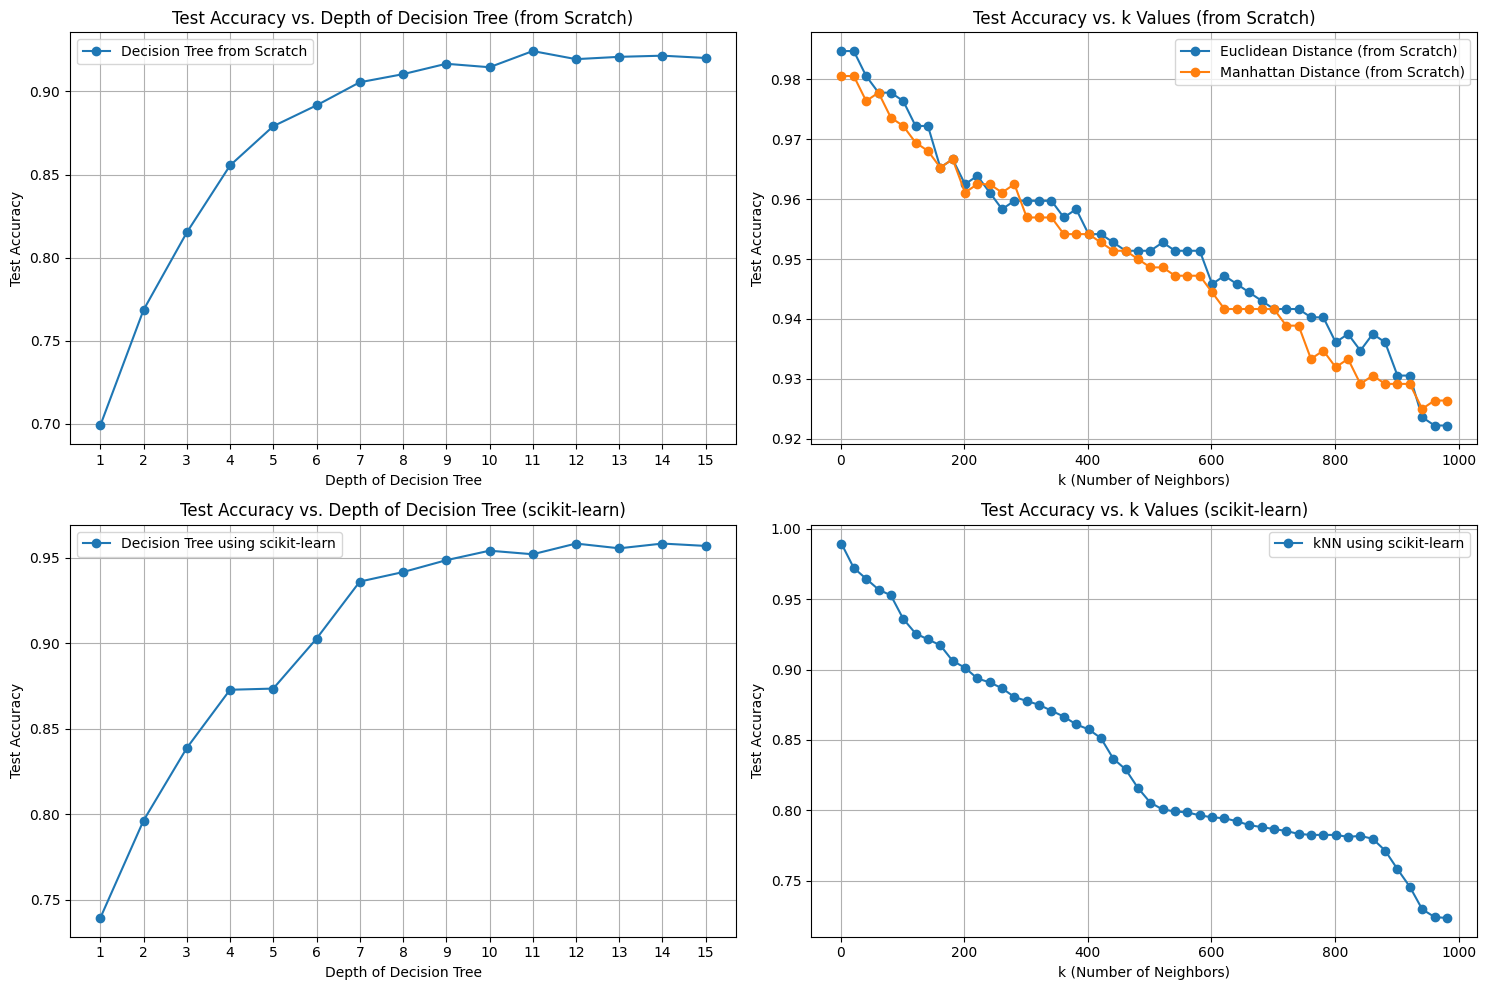

In [ ]:
plt.figure(figsize=(15, 10))

# Plot for Decision Trees from scratch
plt.subplot(2, 2, 1)
plt.plot(depths, test_accuracies, marker='o', label='Decision Tree from Scratch')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Depth of Decision Tree (from Scratch)')
plt.xticks(range(1, 16))
plt.grid(True)
plt.legend()

# Plot for k Nearest Neighbours from scratch
plt.subplot(2, 2, 2)
plt.plot(k_values, test_accuracies_euclidean, label='Euclidean Distance (from Scratch)', marker='o')
plt.plot(k_values, test_accuracies_manhattan, label='Manhattan Distance (from Scratch)', marker='o')
plt.title('Test Accuracy vs. k Values (from Scratch)')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)

# Plot for Decision Trees using scikit-learn
plt.subplot(2, 2, 3)
plt.plot(depths, test_accuracies_dt, marker='o', label='Decision Tree using scikit-learn')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Depth of Decision Tree (scikit-learn)')
plt.xticks(range(1, 16))
plt.grid(True)
plt.legend()

# Plot for k Nearest Neighbours using scikit-learn
plt.subplot(2, 2, 4)
plt.plot(k_values, test_accuracies_knn, label='kNN using scikit-learn', marker='o')
plt.title('Test Accuracy vs. k Values (scikit-learn)')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
